In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import json
import requests
import time
import pandas_datareader as pdr
import datetime
import pandas as pd
import time
import os

In [23]:
# defining key/request url
key = "https://api.binance.com/api/v3/ticker/price?symbol=BTCUSDT"
  
# requesting data from url
data = requests.get(key)
data = data.json()
print(f"{data['symbol']} price is {data['price']}")

BTCUSDT price is 28536.61000000


In [24]:
# coingecko.com
# Get historical market data include price, market cap, and 24h volume within a range of timestamp (granularity auto)
# Data granularity is automatic (cannot be adjusted)
# 1 day from current time = 5 minute interval data
# 1 - 90 days from current time = hourly data
# above 90 days from current time = daily data (00:00 UTC)
# 
# ohlc
# https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=max
# Candle's body:
# 1 - 2 days: 30 minutes
# 3 - 30 days: 4 hours
# 31 days and beyond: 4 days

def get_coingecko_data(coin_name, date_from=0, date_to=int(time.time())):
    # Formatowanie URL-a API
    url = f'https://api.coingecko.com/api/v3/coins/{coin_name}/market_chart/range?vs_currency=usd&from={date_from}&to={date_to}'
    # .format(coin_name, int(time.time()))

    # Pobranie danych z API
    response = requests.get(url)
    data = response.json()

    # Konwersja znaczników czasu i wartości na oddzielne listy
    timestamps_prices = [x[0] for x in data['prices']]
    prices = [x[1] for x in data['prices']]
    timestamps_market_caps = [x[0] for x in data['market_caps']]
    market_caps = [x[1] for x in data['market_caps']]
    timestamps_volumes = [x[0] for x in data['total_volumes']]
    volumes = [x[1] for x in data['total_volumes']]

    # Utworzenie DataFrame dla każdej wartości
    prices_df = pd.DataFrame({'timestamp': timestamps_prices, 'price': prices})
    market_caps_df = pd.DataFrame({'timestamp': timestamps_market_caps, 'market_cap': market_caps})
    volumes_df = pd.DataFrame({'timestamp': timestamps_volumes, 'volume': volumes})

    # Scalenie DataFrame'ów w jeden, wykorzystując kolumnę timestamp jako klucz scalenia
    df_coingecko = prices_df.merge(market_caps_df, on='timestamp', how='outer').merge(volumes_df, on='timestamp', how='outer')

    # Konwersja kolumny timestamp na format daty
    df_coingecko['date'] = pd.to_datetime(df_coingecko['timestamp'], unit='ms').dt.date
    df_coingecko['name'] = coin_name

    # Zapisanie danych do pliku CSV
    filename = f'data/coingecko_{coin_name}_data.csv'
    df_coingecko.to_csv(filename, index=False)

    return df_coingecko

top_coins = ['bitcoin', 'ethereum', 'binancecoin', 'cardano', 'dogecoin']

# Loop through each coin and fetch data, then combine them into one DataFrame
df_list = []
for coin_name in top_coins:
    df_coin = get_coingecko_data(coin_name)
    df_list.append(df_coin)

# Concatenate DataFrames for each coin into one
df_coingecko_coins = pd.concat(df_list, ignore_index=True)
df_coingecko_coins

,timestamp,price,market_cap,volume,date,name
0,1367107200000,135.300000,1.500518e+09,0.000000e+00,2013-04-28,bitcoin
1,1367193600000,141.960000,1.575032e+09,0.000000e+00,2013-04-29,bitcoin
2,1367280000000,135.300000,1.501657e+09,0.000000e+00,2013-04-30,bitcoin
3,1367366400000,117.000000,1.298952e+09,0.000000e+00,2013-05-01,bitcoin
4,1367452800000,103.430000,1.148668e+09,0.000000e+00,2013-05-02,bitcoin
...,...,...,...,...,...,...
13839,1680307200000,0.077230,1.074579e+10,4.725136e+08,2023-04-01,dogecoin
13840,1680393600000,0.081864,1.136781e+10,9.594362e+08,2023-04-02,dogecoin
13841,1680480000000,0.079328,1.100008e+10,1.141871e+09,2023-04-03,dogecoin
13842,1680566400000,0.096152,1.336755e+10,4.502654e+09,2023-04-04,dogecoin


In [25]:
df_coingecko_coins.dtypes

timestamp       int64
price         float64
market_cap    float64
volume        float64
date           object
name           object
dtype: object

<Axes: xlabel='date'>

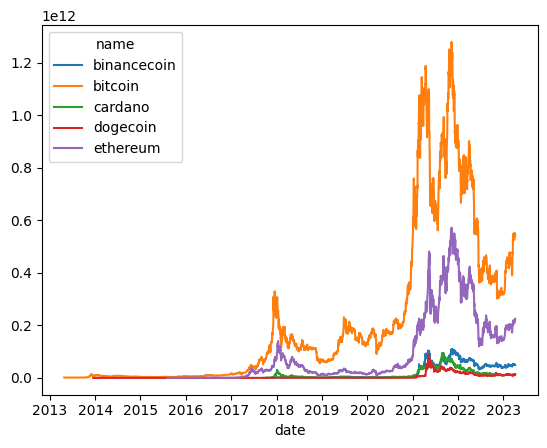

In [26]:
df_coingecko_coins.groupby(['date', 'name'])['market_cap'].mean().unstack().plot()

In [27]:
# https://finance.yahoo.com (1m/7days)

def download_csv_from_yahoo_finance(ticker, period1=1410912000, period2=int(datetime.datetime.now().timestamp()), interval='1d'):
		url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&filter=history'
		return url

# retrive dataset
query_url = download_csv_from_yahoo_finance('BTC-USD')
df_yahoo_BTC = pd.read_csv(query_url)
df_yahoo_BTC.set_index('Date', inplace=True)
df_yahoo_BTC

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-04-01,28473.332031,28802.457031,28297.171875,28411.035156,28411.035156,10876469901
2023-04-02,28462.845703,28518.958984,27884.087891,28199.308594,28199.308594,12284641999
2023-04-03,28183.080078,28475.623047,27276.720703,27790.220703,27790.220703,19556501327


In [28]:
# https://coinmarketcap.com/api/features

# set API endpoint and parameters
url = 'https://pro-api.coinmarketcap.com/v3/cryptocurrency/quotes/historical'
params = {
    'id': '1',
    'convert': 'USD',
    'time_start': '20090101',
    'interval': 'daily'
}

headers = {
    'Accepts':'application/json',
    'X-CMC_PRO_API_KEY':'60e4d324-1f24-42b1-8d2b-66d9a6f57ad0'
}

session = requests.Session()
session.headers.update(headers)

# make API request
response = session.get(url, params=params)

# check if request was successful
if response.status_code == 200:
    # print response text
    print(response.text)
else:
    # print error message
    print(f'Request failed with error code: {response.status_code} - {response.text}')


Request failed with error code: 403 - {
    "status": {
        "timestamp": "2023-04-05T11:39:31.797Z",
        "error_code": 1006,
        "error_message": "Your API Key subscription plan doesn't support this endpoint.",
        "elapsed": 0,
        "credit_count": 0
    }
}


In [61]:
# List of cryptocurrencies to retrieve data for
cryptos = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'ADAUSDT', 'SOLUSDT', 'DOTUSDT',
    'LTCUSDT', 'TRXUSDT', 'DAIUSDT', 'UNIUSDT', 'LEOUSDT', 'ETCUSDT',
    'XLMUSDT', 'XMRUSDT', 'BCHUSDT', 'FILUSDT', 'APTUSDT', 'VETUSDT',
    'APEUSDT', 'ICPUSDT', 'GRTUSDT', 'FTMUSDT', 'EOSUSDT', 'MKRUSDT'
    ]

for crypto in cryptos:
    # Construct the file path for the CSV file to save data to
    csv_file_path = f'data/binance/binance_{crypto}.csv'

    if os.path.exists(csv_file_path):
        # If the file already exists, read the last timestamp to start from the next minute
        df = pd.read_csv(csv_file_path)
        start_date = pd.Timestamp(df.iloc[-1]['open_time'], tz='UTC') + pd.Timedelta(minutes=1)
    else:
        # If the file does not exist, start from the beginning of Bitcoin
        start_date = pd.Timestamp('2009-01-03', tz='UTC')

    end_date = pd.Timestamp.now(tz='UTC')

    print(crypto)
    print(start_date)

    symbol = 'BTCUSDT'
    interval = '1m'
    limit = 1000

    while True:
        start_time = int(start_date.timestamp() * 1000)
        end_time = int(end_date.timestamp() * 1000)

        print(f"Start date for {crypto}: {start_date}")

        # Construct the API URL to retrieve data from Binance
        url = f'https://api.binance.com/api/v3/klines?symbol={crypto}&interval={interval}&startTime={start_time}&endTime={end_time}&limit={limit}'

        # Retrieve data from Binance's API
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            columns = [
                'open_time', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
                'ignored'
            ]
            # Convert the data to a pandas DataFrame
            temp_df = pd.DataFrame(data, columns=columns)
            temp_df['open_time'] = pd.to_datetime(temp_df['open_time'], unit='ms')
            temp_df['close_time'] = pd.to_datetime(temp_df['close_time'], unit='ms')

            print(temp_df.shape[0])

            if not temp_df.empty:
                # Update the start_date to continue from the next minute
                start_date = temp_df['open_time'].iloc[-1] + pd.Timedelta(minutes=1)
                if os.path.exists(csv_file_path):
                    # Append data to an existing CSV file
                    temp_df.to_csv(csv_file_path, mode='a', index=False, header=False)
                else:
                    # Create a new CSV file with header
                    temp_df.to_csv(csv_file_path, mode='a', index=False, header=True)
            else:
                # No more data available, exit the loop
                print(response)
                break

            if temp_df.shape[0] < 1000:
                # If the API response contains less than 1000 rows of data, exit the loop since no more data is available
                break

        else:
            # If the API response status code is not 200, print the error message and break out of the loop
            print(f'Error: {response.json()}')
            break


BTCUSDT
2023-04-05 18:44:00+00:00
Start date for BTCUSDT: 2023-04-05 18:44:00+00:00
729
ETHUSDT
2023-04-05 19:14:00+00:00
Start date for ETHUSDT: 2023-04-05 19:14:00+00:00
699
XRPUSDT
2023-04-05 18:59:00+00:00
Start date for XRPUSDT: 2023-04-05 18:59:00+00:00
714
ADAUSDT
2023-04-02 14:06:00+00:00
Start date for ADAUSDT: 2023-04-02 14:06:00+00:00
1000
Start date for ADAUSDT: 2023-04-03 06:46:00
1000
Start date for ADAUSDT: 2023-04-03 23:26:00
1000
Start date for ADAUSDT: 2023-04-04 16:06:00
1000
Start date for ADAUSDT: 2023-04-05 08:46:00
1000
Start date for ADAUSDT: 2023-04-06 01:26:00
327
SOLUSDT
2023-04-05 11:30:00+00:00
Start date for SOLUSDT: 2023-04-05 11:30:00+00:00
1000
Start date for SOLUSDT: 2023-04-06 04:10:00
164
DOTUSDT
2023-04-03 12:55:00+00:00
Start date for DOTUSDT: 2023-04-03 12:55:00+00:00
1000
Start date for DOTUSDT: 2023-04-04 05:35:00
1000
Start date for DOTUSDT: 2023-04-04 22:15:00
1000
Start date for DOTUSDT: 2023-04-05 14:55:00
959
LTCUSDT
2020-05-01 15:22:00+00:

In [ ]:
# # List of cryptocurrencies to retrieve data for
# # List of cryptocurrencies to retrieve data for
# cryptos = [
#     'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'ADAUSDT', 'SOLUSDT', 'DOTUSDT',
#     'LTCUSDT', 'TRXUSDT', 'DAIUSDT', 'UNIUSDT', 'LEOUSDT', 'ETCUSDT',
#     'XLMUSDT', 'XMRUSDT', 'BCHUSDT', 'FILUSDT', 'APTUSDT', 'VETUSDT',
#     'APEUSDT', 'ICPUSDT', 'GRTUSDT', 'FTMUSDT', 'EOSUSDT', 'MKRUSDT'
# ]

# for crypto in cryptos:
#     # Construct the file path for the CSV file to save data to
#     csv_file_path = f'data/binance/binance_{crypto}.csv'

#     if os.path.exists(csv_file_path):
#         # If the file already exists, read the last timestamp to start from the next minute
#         df = pd.read_csv(csv_file_path)
#         start_date = pd.Timestamp(df.iloc[-1]['open_time'], tz='UTC') + pd.Timedelta(minutes=1)
#     else:
#         # If the file does not exist, start from the beginning of Bitcoin
#         start_date = pd.Timestamp('2009-01-03', tz='UTC')

#     end_date = pd.Timestamp.now(tz='UTC')

#     print(crypto)
#     print(start_date)

#     symbol = 'BTCUSDT'
#     interval = '1m'
#     limit = 1000

#     while True:
#         start_time = int(start_date.timestamp() * 1000)
#         end_time = int(end_date.timestamp() * 1000)

#         print(f"Start date for {crypto}: {start_date}")

#         # Construct the API URL to retrieve data from Binance
#         url = f'https://api.binance.com/api/v3/klines?symbol={crypto}&interval={interval}&startTime={start_time}&endTime={end_time}&limit={limit}'

#         # Retrieve data from Binance's API
#         response = requests.get(url)

#         if response.status_code == 200:
#             data = response.json()
#             columns = [
#                 'open_time', 'open', 'high', 'low', 'close', 'volume',
#                 'close_time', 'quote_asset_volume', 'number_of_trades',
#                 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
#             ]
#             # Convert the data to a pandas DataFrame and drop the 'ignored' column
#             temp_df = pd.DataFrame(data, columns=columns).drop('ignored', axis=1)
#             temp_df['open_time'] = pd.to_datetime(temp_df['open_time'], unit='ms')
#             temp_df['close_time'] = pd.to_datetime(temp_df['close_time'], unit='ms')
#             temp_df['symbol'] = symbol.replace("USDT", "").lower()

#             print(temp_df.shape[0])

#             if not temp_df.empty:
#                 # Update the start_date to continue from the next minute
#                 start_date = temp_df['open_time'].iloc[-1] + pd.Timedelta(minutes=1)
#                 if os.path.exists(csv_file_path):
#                     # Append data to an existing CSV file
#                     temp_df.to_csv(csv_file_path, mode='a', index=False, header=False)
#                 else:
#                     # Create a new CSV file with header
#                     temp_df.to_csv(csv_file_path, mode='a', index=False, header=True)
#             else:
#                 # No more data available, exit the loop
#                 print(response)
#                 break

#             if temp_df.shape[0] < 1000:
#                 # If the API response contains less than 1000 rows of data, exit the loop since no more data is available
#                 break

#         else:
#             # If the API response status code is not 200, print the error message and break out of the loop
#             print(f'Error: {response.json()}')
#             break

In [2]:
import glob
import pandas as pd

csv_files = glob.glob("data/binance/*.csv")

df_binance = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    filename = csv_file.split("/")[-1].split(".")[0]
    symbol = filename.split("_")[1].replace("USDT", "").lower()
    df['symbol'] = symbol
    df_binance = pd.concat([df_binance, df], ignore_index=True)

df_binance['open_time'] = pd.to_datetime(df_binance['open_time'])
df_binance['close_time'] = pd.to_datetime(df_binance['close_time'])

print(df_binance.dtypes)


open_time                       datetime64[ns]
open                                   float64
high                                   float64
low                                    float64
close                                  float64
volume                                 float64
close_time                      datetime64[ns]
quote_asset_volume                     float64
number_of_trades                         int64
taker_buy_base_asset_volume            float64
taker_buy_quote_asset_volume           float64
ignored                                float64
symbol                                  object
dtype: object


In [4]:
df_binance.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignored,symbol
0,2018-04-17 04:02:00,0.25551,0.27000,0.25551,0.27000,111061.62,2018-04-17 04:02:59.999,28743.075452,15,105736.42,27380.973451,0.0,ada
1,2018-04-17 04:03:00,0.27000,0.27000,0.26100,0.26108,65024.98,2018-04-17 04:03:59.999,17479.678430,24,61630.17,16577.948911,0.0,ada
2,2018-04-17 04:04:00,0.26121,0.26729,0.26120,0.26666,92526.73,2018-04-17 04:04:59.999,24380.131101,38,42216.91,11179.347383,0.0,ada
3,2018-04-17 04:05:00,0.26700,0.26800,0.26500,0.26666,75961.21,2018-04-17 04:05:59.999,20318.501087,66,49318.54,13197.524071,0.0,ada
4,2018-04-17 04:06:00,0.26770,0.26998,0.26700,0.26995,362270.32,2018-04-17 04:06:59.999,97069.547354,145,93278.18,25004.202176,0.0,ada


In [34]:
# https://docs.bitfinex.com/docs

# List of cryptocurrencies to retrieve data for
cryptos = ['BTC', 'ETH', 'XRP', 'ADA', 'SOL', 'DOT', 'LTC', 'TRX', 'DAI', 'UNI', 'LEO', 'ETC', 'XLM', 'XMR', 'BCH', 'FIL', 'APT', 'VET', 'APE', 'ICP', 'GRT', 'FTM', 'EOS', 'MKR']

for crypto in cryptos:

    # Construct the API URL and CSV file path
    url = f'https://api-pub.bitfinex.com/v2/candles/trade:1m:t{crypto}USD/hist'
    csv_file_path = f'data/bitfinex/{crypto}_usd_candles_bitfinex.csv'

    # If the CSV file already exists, read the last timestamp to start from the next minute
    # Otherwise, start from the beginning of Bitfinex's trading history
    if os.path.exists(csv_file_path):
        df = pd.read_csv(csv_file_path)
        start_date = pd.Timestamp(df.iloc[-1]['open_time'], tz='UTC') + pd.Timedelta(minutes=1)
    else:
        start_date = pd.Timestamp('2009-01-03', tz='UTC')

    # Define the column headers for the CSV file
    header = ['open_time', 'open', 'close', 'high', 'low', 'volume']

    # Create an empty DataFrame to store the data
    temp_df = pd.DataFrame(columns=header)

    # Retrieve data from Bitfinex's API
    while True:

        params = {
            'sort': 1,
            'start': int(start_date.timestamp() * 1000),
            'limit': 10000,
            'section': 'hist'
        }

        print(f"Start date for {crypto}: {start_date}")

        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            temp_df = pd.DataFrame(data, columns=header)
            temp_df['open_time'] = pd.to_datetime(temp_df['open_time'], unit='ms')
            # temp_df['symbol'] = symbol.replace("USDT", "").lower()

            if not temp_df.empty:
                # Update the start_date to continue from the next minute
                start_date = temp_df['open_time'].iloc[-1] + pd.Timedelta(minutes=1)
                if os.path.exists(csv_file_path):
                    # Append data to an existing CSV file
                    temp_df.to_csv(csv_file_path, mode='a', index=False, header=False)
                else:
                    # Create a new CSV file with header
                    temp_df.to_csv(csv_file_path, mode='a', index=False, header=True)
            else:
                # No more data available, exit the loop
                print(response)
                break

            # Exit the loop if the response contains less than 10000 rows of data
            if temp_df.shape[0] < 10000:
                break

        else:
            # If the API response status code is not 200, print the error message
            print(f"Error: {response.status_code}")

        # Add a short delay to avoid hitting rate limits
        time.sleep(1) 


Start date for BNB: 2009-01-03 00:00:00+00:00
<Response [200]>
Start date for ADA: 2023-04-05 11:53:00+00:00
Start date for LINK: 2009-01-03 00:00:00+00:00
<Response [200]>
Start date for DOGE: 2009-01-03 00:00:00+00:00
<Response [200]>
Start date for ETC: 2023-04-05 12:13:00+00:00
Start date for MKR: 2009-01-03 00:00:00+00:00
Start date for MKR: 2019-07-15 14:04:00
Start date for MKR: 2020-08-12 12:49:00
Start date for MKR: 2021-02-21 01:34:00
Start date for MKR: 2021-05-05 08:43:00
Start date for MKR: 2021-09-13 14:55:00
Start date for MKR: 2021-12-03 10:41:00
Start date for MKR: 2022-01-09 23:06:00
Start date for MKR: 2022-01-30 20:18:00
Start date for MKR: 2022-02-23 17:50:00
Start date for MKR: 2022-03-17 13:02:00
Start date for MKR: 2022-04-09 12:58:00
Start date for MKR: 2022-05-04 03:07:00
Start date for MKR: 2022-05-20 10:32:00
Start date for MKR: 2022-06-09 13:15:00
Start date for MKR: 2022-06-27 20:03:00
Start date for MKR: 2022-07-18 10:28:00
Start date for MKR: 2022-08-07 

In [3]:
import glob

csv_files = glob.glob("data/bitfinex/*.csv")

df_bitfinex = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    filename = csv_file.split("/")[-1].split(".")[0]
    symbol = filename.split("_")[0].lower()
    df['symbol'] = symbol
    df_bitfinex = pd.concat([df_bitfinex, df], ignore_index=True)

df_bitfinex['open_time'] = pd.to_datetime(df_bitfinex['open_time'])
df_bitfinex['close_time'] = df_bitfinex['open_time'] + pd.Timedelta(minutes=1) - pd.Timedelta(milliseconds=1)

print(df_bitfinex.dtypes)

open_time     datetime64[ns]
open                 float64
close                float64
high                 float64
low                  float64
volume               float64
symbol                object
close_time    datetime64[ns]
dtype: object


In [8]:
print(df_binance.duplicated().sum())
print(df_bitfinex.duplicated().sum())


0


In [22]:
print(df_binance.isnull().sum())
print(df_bitfinex.isnull().sum())

open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ignored                         1
dtype: int64
open_time     0
open          0
close         0
high          0
low           0
volume        0
close_time    0
dtype: int64


In [40]:
df_binance = df_binance.drop('ignored', axis=1)
print(df_binance)

                   open_time     open     high      low    close     volume  \
0        2018-04-17 04:02:00  0.25551  0.27000  0.25551  0.27000  111061.62   
1        2018-04-17 04:03:00  0.27000  0.27000  0.26100  0.26108   65024.98   
2        2018-04-17 04:04:00  0.26121  0.26729  0.26120  0.26666   92526.73   
3        2018-04-17 04:05:00  0.26700  0.26800  0.26500  0.26666   75961.21   
4        2018-04-17 04:06:00  0.26770  0.26998  0.26700  0.26995  362270.32   
...                      ...      ...      ...      ...      ...        ...   
42267857 2023-04-06 06:48:00  0.50350  0.50370  0.50330  0.50340  217848.00   
42267858 2023-04-06 06:49:00  0.50330  0.50340  0.50320  0.50340   85102.00   
42267859 2023-04-06 06:50:00  0.50330  0.50380  0.50330  0.50380  371882.00   
42267860 2023-04-06 06:51:00  0.50370  0.50380  0.50350  0.50360  122194.00   
42267861 2023-04-06 06:52:00  0.50350  0.50380  0.50350  0.50370   32156.00   

                      close_time  quote_asset_volum

In [ ]:
# https://docs.coinapi.io/market-data/rest-api/ohlcv free 100 Daily requests

# Set the API endpoint URL and headers
exchange = "BITSTAMP"
coin = "BTC"
to = "USD"
symbol_id = f"{exchange}_SPOT_{coin}_{to}"
url = f"https://rest.coinapi.io/v1/ohlcv/{symbol_id}/history?period_id=1MIN&time_start=2015-08-07T00:00:00"
headers = {'X-CoinAPI-Key': 'C0A6B24D-51B0-4C13-9C7B-52F9BDABDEAC'}

# Set the path and filename for the CSV file
csv_file_path = 'data/coinapi/eth_usd_candles_bitstamp.csv'

# Check if the file already exists and get the start date for new data
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
    start_date = pd.Timestamp(df.iloc[-1]['time_period_start'], tz='UTC') + pd.Timedelta(minutes=1)
else:
    start_date = pd.Timestamp('2009-01-03', tz='UTC')

# Define the header for the CSV file
header = ['time_period_start', 'time_period_end', 'time_open', 'time_close', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded', 'trades_count']

# Loop indefinitely to fetch new data
while True:

    params = {
    'period_id': '1MIN',
    'time_start': start_date.isoformat(),
    'limit': 5000,
    'include_empty_items': 'false'
    }

    print(start_date)
    # Fetch the candles
    response = requests.get(url, headers=headers, params=params)
    print(response)

    # Check if the response was successful
    if response.status_code == 200:
        data = response.json()
        temp_df = pd.DataFrame(data, columns=header)
        temp_df['time_period_start'] = pd.to_datetime(temp_df['time_period_start'])
        temp_df['time_period_end'] = pd.to_datetime(temp_df['time_period_end'])
        
        if not temp_df.empty:
            start_date = temp_df['time_period_start'].iloc[-1] + pd.Timedelta(minutes=1)
            if os.path.exists(csv_file_path):
                temp_df.to_csv(csv_file_path, mode='a', index=False, header=False)
            else:
                temp_df.to_csv(csv_file_path, mode='a', index=False, header=True)

            if temp_df.shape[0] < 100:
                        break
        
        time.sleep(1)
                
    else:
        print(f"Error: {response.status_code}")

    time.sleep(1)  # add a short delay to avoid hitting rate limits


2015-08-10 11:21:00+00:00
<Response [200]>
2015-08-10 11:21:00+00:00
<Response [200]>
2015-08-10 11:21:00+00:00
<Response [200]>
2015-08-10 11:21:00+00:00
<Response [200]>
2015-08-10 11:21:00+00:00
<Response [429]>
Error: 429
2015-08-10 11:21:00+00:00
<Response [429]>
Error: 429
2015-08-10 11:21:00+00:00
<Response [429]>
Error: 429
2015-08-10 11:21:00+00:00
<Response [429]>
Error: 429
2015-08-10 11:21:00+00:00
<Response [429]>
Error: 429


KeyboardInterrupt: 

In [7]:
import requests

# zapytanie o informacje o kryptowalucie Bitcoin
response = requests.get("https://api.coingecko.com/api/v3/coins/bitcoin")

# pobranie informacji o liczbie jednostek w obiegu
circulating_supply = response.json()["market_data"]["circulating_supply"]

print(f"Liczba jednostek w obiegu dla Bitcoin: {circulating_supply}")


Liczba jednostek w obiegu dla Bitcoin: 19339481.0


TypeError: 'Figure' object is not callable

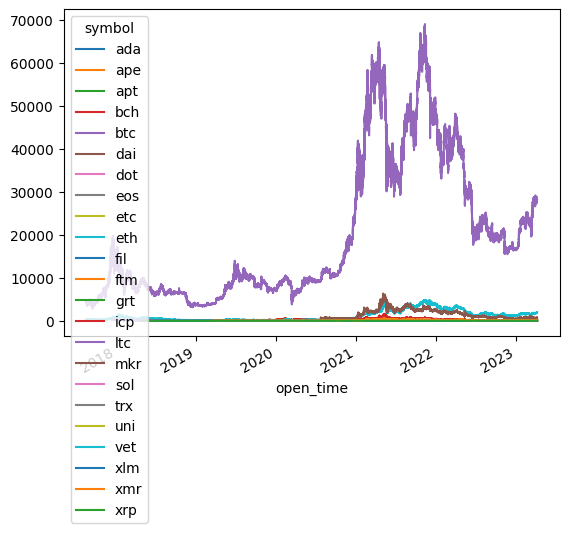

In [29]:
df_binance.groupby(['open_time', 'symbol'])['close'].mean().unstack().plot()

# wykres high
plt.figure(figsize=(25, 5))
plt.plot(df_binance['open_time'], df_binance['close'])
plt.title('High BTCUSDT binance')
plt.xlabel('Time')
plt.ylabel('High')
plt.show()

In [ ]:
# # Wczytaj pierwszy wiersz z pliku CSV
# df_first = pd.read_csv('data/binance_BTCUSDT.csv', nrows=1)

# # Wczytaj ostatni wiersz z pliku CSV
# nrows = 1
# skiprows = range(1, len(pd.read_csv('data/binance_BTCUSDT.csv')) - nrows - 1)
# df_last = pd.read_csv('data/binance_BTCUSDT.csv', nrows=nrows, skiprows=skiprows)

# # Wyświetl pierwszy i ostatni wiersz
# print(df_first)
# print(df_last)


# Wczytanie pliku CSV
df = pd.read_csv('data/btc_usd_candles.csv')

df
# Sprawdzenie duplikatów
duplicates = df.duplicated()
if duplicates.any():
    print(f'Znaleziono duplikaty: {duplicates.sum()}')
    df = df.drop_duplicates()
else:
    print('Nie znaleziono duplikatów')

# Konwersja kolumny 'open_time' na typ datetime
df['open_time'] = pd.to_datetime(df['open_time'], format='%Y-%m-%d %H:%M:%S')

# Sortowanie wg czasu
df.sort_values('open_time', inplace=True)

# Sprawdzenie, czy daty są uporządkowane w odstępach 1 minuty
time_diff = df['open_time'].diff()
mask = time_diff != pd.Timedelta(minutes=1)
if mask.any():
    print('Daty, które nie wpasowują się w odstępy 1 minuty:')
    print(df.loc[mask])
else:
    print('Daty są uporządkowane w odstępach 1 minuty')

Nie znaleziono duplikatów
Daty, które nie wpasowują się w odstępy 1 minuty:
                  open_time         open        close         high  \
0       2013-04-01 00:07:00     93.25000     93.30000     93.30000   
3       2013-04-01 00:11:00     93.35000     93.47000     93.47000   
6       2013-04-01 00:26:00     93.04399     93.04399     93.04399   
7       2013-04-01 00:28:00     93.34999     93.35000     93.35000   
8       2013-04-01 00:35:00     93.19999     93.35000     93.35000   
...                     ...          ...          ...          ...   
4326696 2023-04-04 20:27:00  28183.00000  28184.00000  28184.00000   
4326700 2023-04-04 20:28:00  28180.00000  28179.00000  28180.00000   
4326701 2023-04-04 20:28:00  28180.00000  28179.00000  28180.00000   
4326702 2023-04-04 20:28:00  28180.00000  28179.00000  28180.00000   
4327207 2023-04-05 04:54:00  28503.00000  28496.00000  28503.00000   

                 low     volume  
0           93.25000  93.300000  
3           93.

<Axes: xlabel='symbol'>

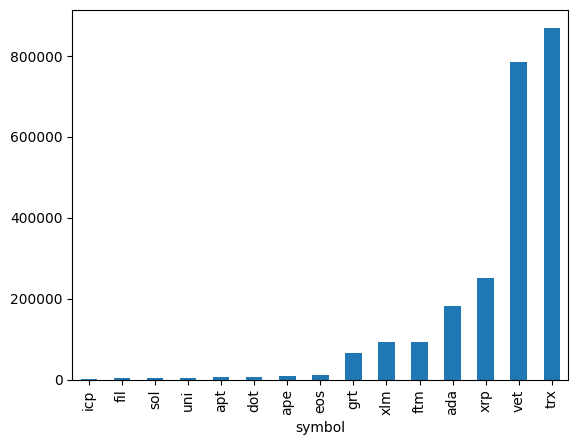

In [11]:
df_binance.groupby(['symbol'])['volume'].mean().sort_values(ascending=False).head(15).sort_values().plot(kind='bar')

<Axes: xlabel='symbol'>

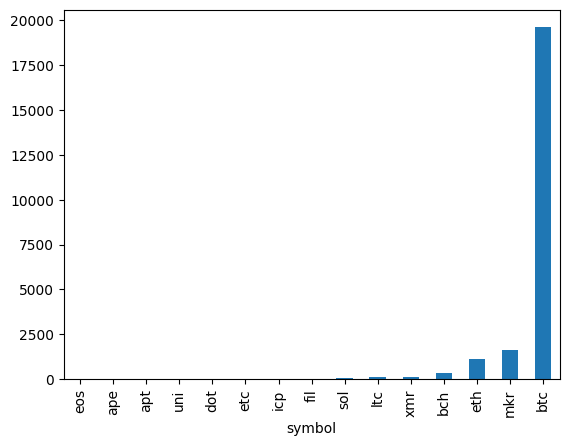

In [14]:
df_binance.groupby(['symbol'])['close'].mean().sort_values(ascending=False).head(15).sort_values().plot(kind='bar')

<Axes: xlabel='symbol'>

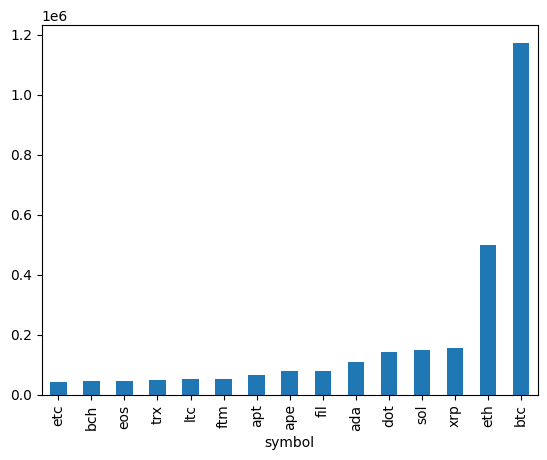

In [15]:
# wartość wolumenu w walucie kwotowania (suma wartości wszystkich transakcji (kupna i sprzedaży) przeliczona na walutę kwotowania)
df_binance.groupby(['symbol'])['quote_asset_volume'].mean().sort_values(ascending=False).head(15).sort_values().plot(kind='bar')

<Axes: xlabel='symbol'>

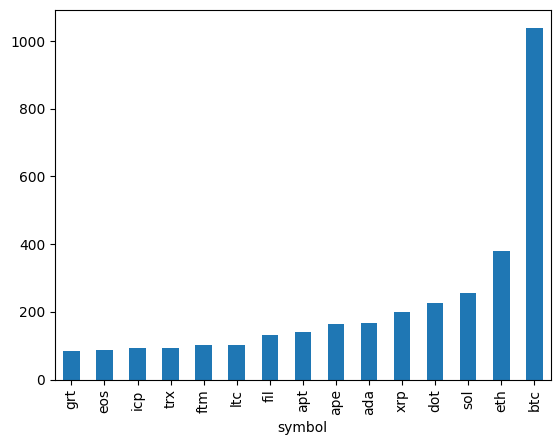

In [18]:
# liczba transakcji wykonanych w przedziale czasowym
df_binance.groupby(['symbol'])['number_of_trades'].mean().sort_values(ascending=False).head(15).sort_values().plot(kind='bar')

<Axes: xlabel='symbol'>

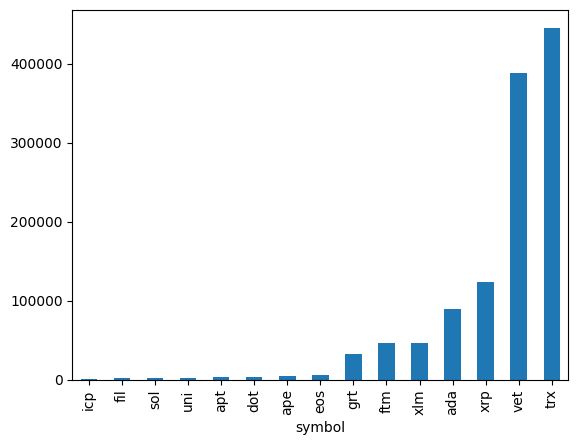

In [23]:
# wolumen kupujących wykonujących transakcje typu taker, którzy kupili bazową walutę (ilosc waluty zakupionej przy transakcji)
df_binance.groupby(['symbol'])['taker_buy_base_asset_volume'].mean().sort_values(ascending=False).head(15).sort_values().plot(kind='bar')

<Axes: xlabel='symbol'>

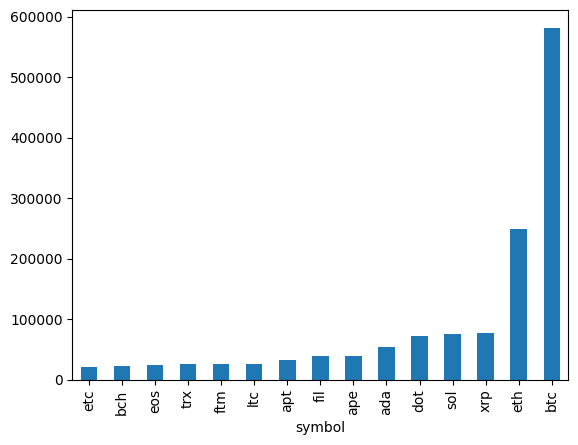

In [22]:
# wolumen kupujących wykonujących transakcje typu taker, którzy kupili walutę kwotowania (ilość USDT zapłaconych przy transakcji)
df_binance.groupby(['symbol'])['taker_buy_quote_asset_volume'].mean().sort_values(ascending=False).head(15).sort_values().plot(kind='bar')

<Axes: xlabel='open_time'>

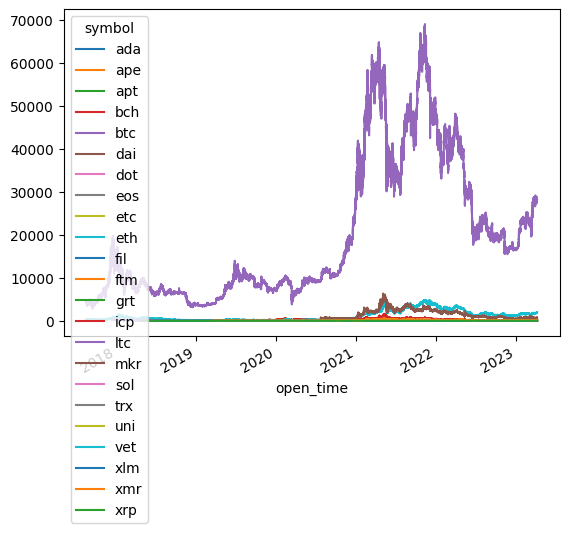

In [26]:
df_binance.groupby(['open_time', 'symbol'])['close'].mean().unstack().plot()


<Axes: xlabel='symbol', ylabel='symbol'>

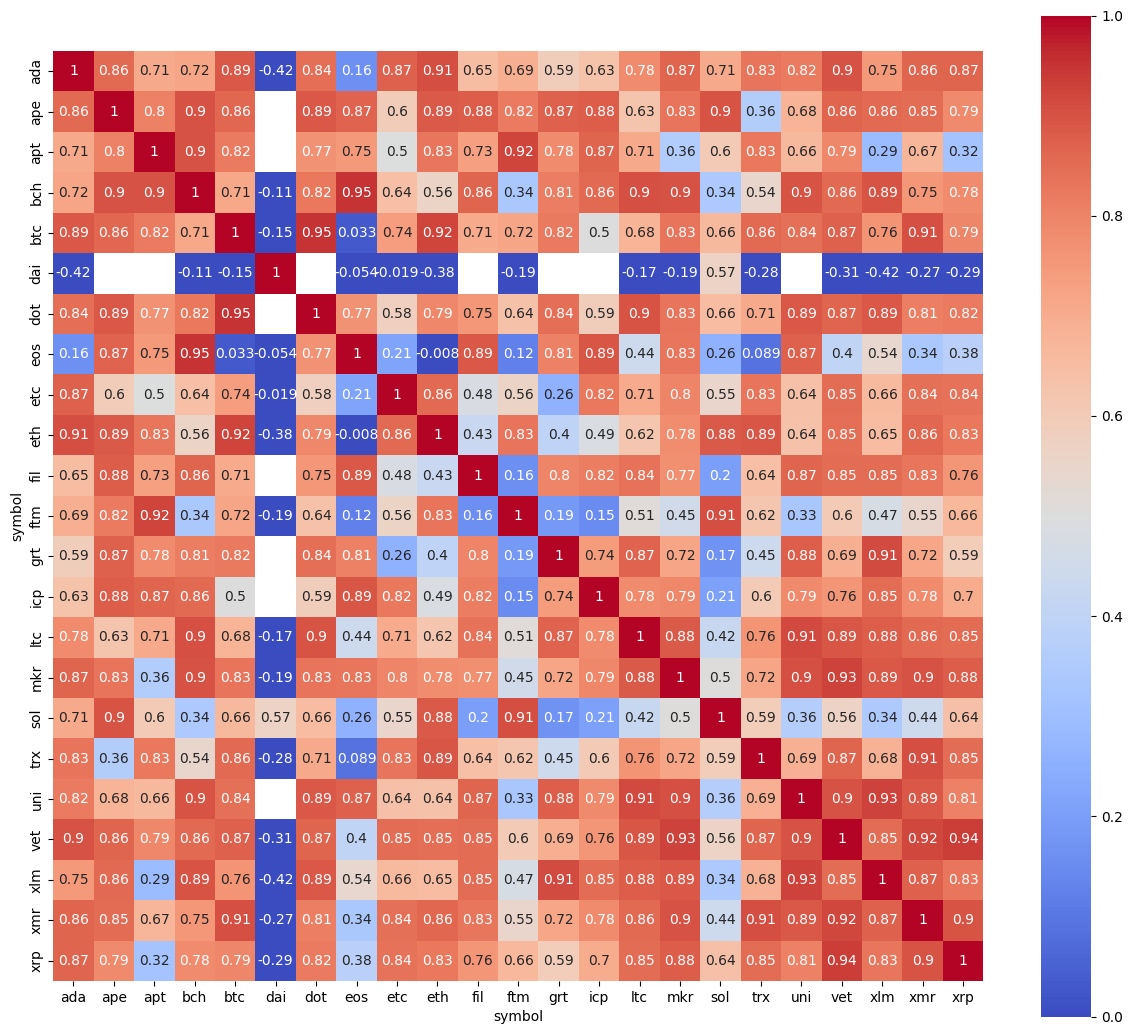

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

binance_currencies_in_time = df_binance.groupby(['open_time', 'symbol'])['close'].last().unstack()
fig, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(binance_currencies_in_time.corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True, square=True, ax=ax)


C:\Users\poter\AppData\Local\Temp\ipykernel_29628\3363595564.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_btc_binance.corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True, square=True, ax=ax)


<Axes: >

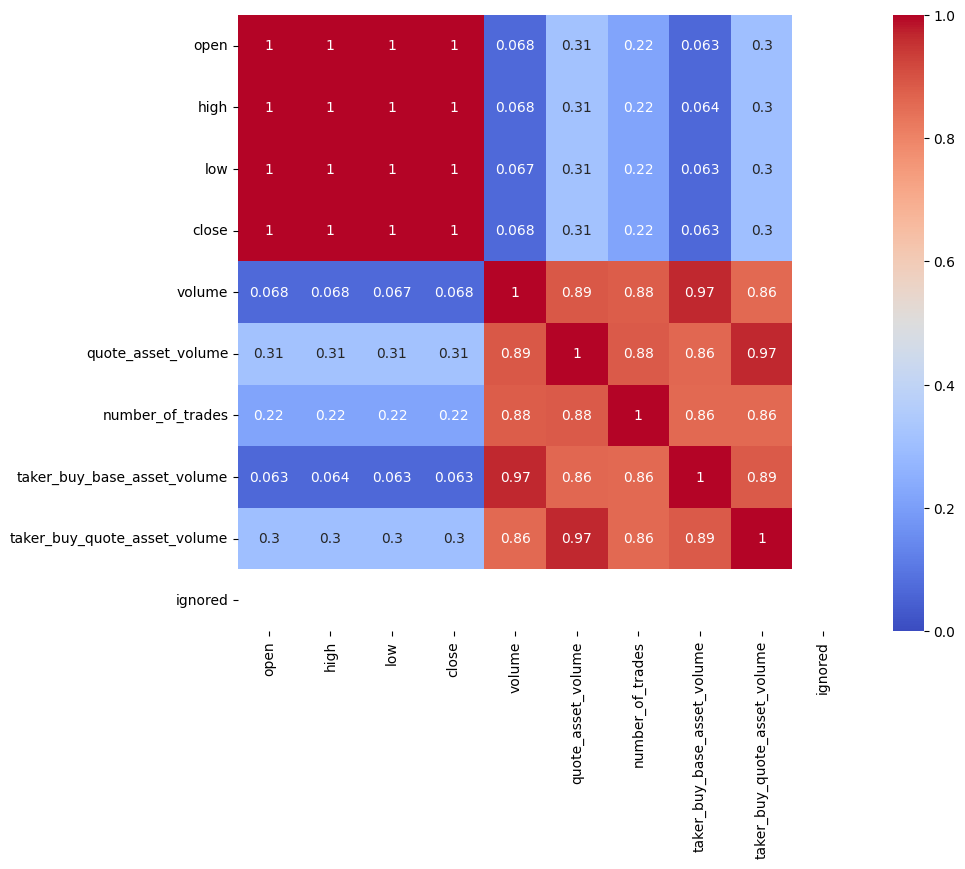

In [6]:
df_btc_binance = df_binance[df_binance['symbol'] == 'btc']

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_btc_binance.corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True, square=True, ax=ax)

In [3]:
df_btc_binance = df_binance[df_binance['symbol'] == 'btc']

numeric_cols = df_btc_binance.select_dtypes(include=["float64", "int64"])
sns.pairplot(numeric_cols)

KeyboardInterrupt: 

In [ ]:
# Class for records in tables
class Record:
    def __init__(self, **kwargs):
        self.properties = kwargs

        # Add attributes to the object for each column
        for key, value in kwargs.items():
            setattr(self, key, value)

    def __str__(self):
        return str(self.properties)

record_list = []

# Create objects of the Record class from all table's rows
record_list = [Record(**row._asdict()) for row in df.itertuples()]


print(record_list[0].date)
print(len(record_list))